# Лабораторная работа 4.1 Построение и оценка модели для прогнозирования оттока клиентов

**Тема.** Интерпретация результатов модели для принятия бизнес-решений

**Курс.** Python для анализа данных

**Специальность.** Бизнес-информатика

### Цель работы:
Научиться применять модели машинного обучения (регрессию и классификацию) для решения реальных бизнес-задач, а также интерпретировать полученные результаты для формирования практических рекомендаций и принятия управленческих решений.

---

## Машинное обучение как инструмент бизнес-аналитика

В современном бизнесе данные — это стратегический актив. Способность предсказывать будущее поведение клиентов, оценивать риски и оптимизировать процессы напрямую влияет на прибыльность компании. Машинное обучение (ML) предоставляет для этого мощный инструментарий.

**Сквозной бизнес-кейс.** На протяжении всей этой работы мы будем решать одну из самых классических и важных задач — **прогнозирование оттока клиентов (Customer Churn)** на примере телеком-оператора.

**Почему это важно для бизнеса?**
- **Прямые финансовые потери.** Потерянный клиент — это потерянный доход.
- **Высокая стоимость привлечения.** Привлечь нового клиента в 5-7 раз дороже, чем удержать существующего.

Наша цель — не просто построить модель, которая предсказывает отток, а понять, **как использовать её результаты для реальных действий**: кому из клиентов предложить скидку, на какие факторы обратить внимание, чтобы снизить отток в будущем.

## Часть 1. Подготовка к анализу

Импортируем необходимые библиотеки и загрузим наш датасет.

In [1]:
# Импорт основных библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Импорт инструментов для предобработки данных
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Импорт моделей
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier

# Импорт метрик для оценки
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.metrics import mean_squared_error, r2_score

# Настройки для визуализаций
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)

**Задание 1: Загрузка и первичный осмотр данных**

Загрузите датасет по оттоку клиентов телеком-оператора по предоставленной ссылке. Выведите первые 5 строк (`.head()`) и общую информацию о данных (`.info()`).

In [2]:
# Задание 1
# URL датасета
url = 'https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv'

# Ваш код здесь
# 1. Загрузите данные в DataFrame 'df'
df = pd.read_csv(url)

# 2. Выведите первые 5 строк
print("Первые 5 строк датасета:")
display(df.head())

# 3. Выведите информацию о DataFrame
print("\nИнформация о датасете:")
df.info()


Первые 5 строк датасета:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes



Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  

## Часть 2. Исследовательский анализ данных (EDA) для бизнес-гипотез

Цель EDA — не просто посмотреть на данные, а найти в них инсайты, которые помогут нам в дальнейшем моделировании и принятии решений.

**Задание 2. Анализ целевой переменной**

Наша целевая переменная для задачи классификации — столбец `Churn` (Отток). Постройте столбчатую диаграмму (`countplot` из seaborn), чтобы визуализировать распределение классов. Сделайте вывод о сбалансированности классов.

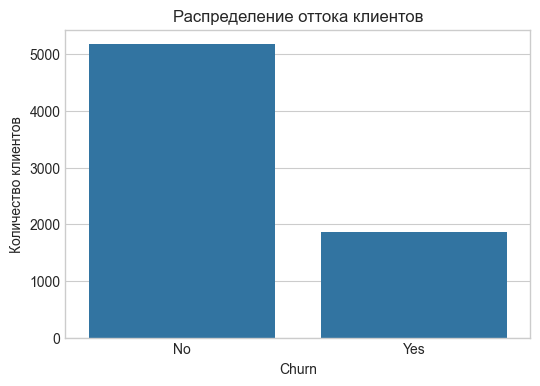

Распределение классов:
Churn
No     5174
Yes    1869
Name: count, dtype: int64

Процентное соотношение:
Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64

Анализ сбалансированности:
Классы сильно несбалансированы (соотношение < 40%).
Обязательно использовать метрики precision, recall, F1-score, ROC-AUC.
Рекомендуется применить методы балансировки классов (SMOTE, undersampling, class_weight).

Соотношение классов: 36.12%


In [ ]:
# Задание 2
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Churn')
plt.title('Распределение оттока клиентов')
plt.ylabel('Количество клиентов')
plt.show()

# Количественный анализ
print("Распределение классов:")
print(df['Churn'].value_counts())
print("\nПроцентное соотношение:")
churn_percentages = df['Churn'].value_counts(normalize=True) * 100
print(churn_percentages)

# Автоматический вывод о сбалансированности классов
min_percentage = churn_percentages.min()
max_percentage = churn_percentages.max()
ratio = min_percentage / max_percentage

print("\nАнализ сбалансированности:")
if ratio >= 0.8:
    print("Классы сбалансированы (соотношение >= 80%).")
elif ratio >= 0.6:
    print("Классы умеренно несбалансированы (соотношение 60-80%).")
    print("Рекомендуется использовать метрики precision, recall, F1-score при оценке модели.")
elif ratio >= 0.4:
    print("Классы заметно несбалансированы (соотношение 40-60%).")
    print("Необходимо использовать метрики precision, recall, F1-score и рассмотреть методы балансировки классов.")
else:
    print("Классы сильно несбалансированы (соотношение < 40%).")
    print("Обязательно использовать метрики precision, recall, F1-score, ROC-AUC.")
    print("Рекомендуется применить методы балансировки классов (SMOTE, undersampling, class_weight).")

print(f"\nСоотношение классов: {ratio:.2%}")

**Задание 3: Влияние типа контракта на отток**

**Бизнес-гипотеза.** Клиенты с краткосрочными контрактами (Month-to-month) более склонны к оттоку.
Проверьте эту гипотезу, построив `countplot` для столбца `Contract`, разделив его по значениям `Churn` (используйте параметр `hue`).

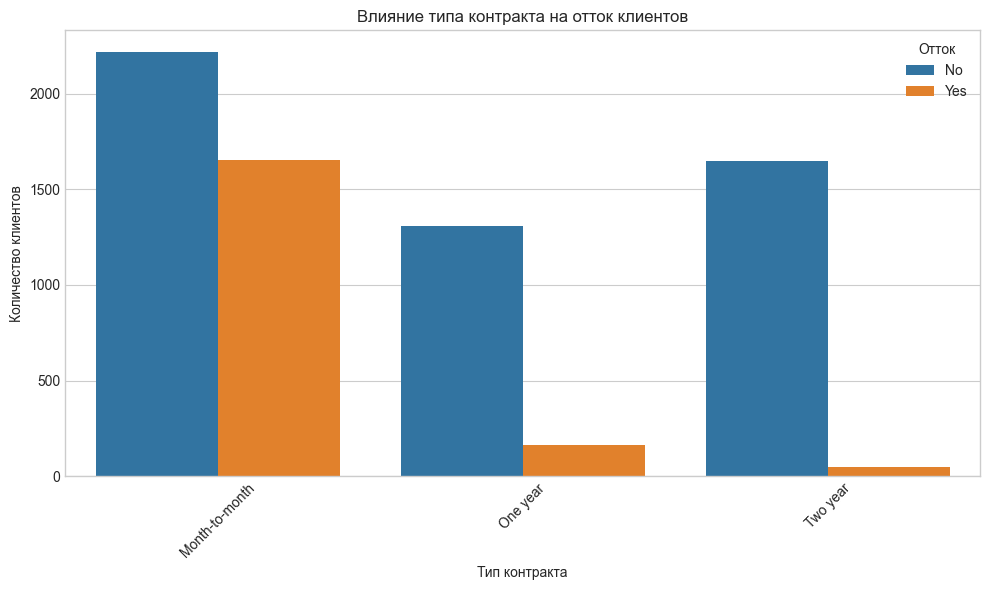


Распределение оттока по типам контрактов:
Churn                  No        Yes
Contract                            
Month-to-month  57.290323  42.709677
One year        88.730482  11.269518
Two year        97.168142   2.831858

Процент оттока по типам контрактов:
Contract
Month-to-month    42.709677
One year          11.269518
Two year           2.831858
Name: Churn, dtype: float64

Проверка гипотезы:
Гипотеза подтверждена: клиенты с контрактом Month-to-month имеют более высокий процент оттока (42.7%)
  по сравнению с другими типами контрактов (средний 7.1%)


In [6]:
# Задание 3
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Contract', hue='Churn')
plt.title('Влияние типа контракта на отток клиентов')
plt.xlabel('Тип контракта')
plt.ylabel('Количество клиентов')
plt.legend(title='Отток', loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Количественный анализ для проверки гипотезы
print("\nРаспределение оттока по типам контрактов:")
contract_churn = pd.crosstab(df['Contract'], df['Churn'], normalize='index') * 100
print(contract_churn)
print("\nПроцент оттока по типам контрактов:")
churn_by_contract = df.groupby('Contract')['Churn'].apply(lambda x: (x == 'Yes').sum() / len(x) * 100)
print(churn_by_contract)

# Проверка гипотезы
print("\nПроверка гипотезы:")
if 'Month-to-month' in churn_by_contract.index:
    month_to_month_churn = churn_by_contract['Month-to-month']
    other_contracts_churn = churn_by_contract[churn_by_contract.index != 'Month-to-month'].mean()
    
    if month_to_month_churn > other_contracts_churn:
        print(f"Гипотеза подтверждена: клиенты с контрактом Month-to-month имеют более высокий процент оттока ({month_to_month_churn:.1f}%)")
        print(f"  по сравнению с другими типами контрактов (средний {other_contracts_churn:.1f}%)")
    else:
        print(f"Гипотеза не подтверждена: клиенты с контрактом Month-to-month имеют процент оттока {month_to_month_churn:.1f}%")
        print(f"  что не выше среднего по другим типам контрактов ({other_contracts_churn:.1f}%)")


**Задание 4. Влияние ежемесячных платежей на отток**

**Бизнес-гипотеза.** Клиенты с более высокими ежемесячными платежами чаще уходят.
Проверьте это, построив `boxplot` (ящик с усами), где по оси X будет `Churn`, а по оси Y — `MonthlyCharges`.

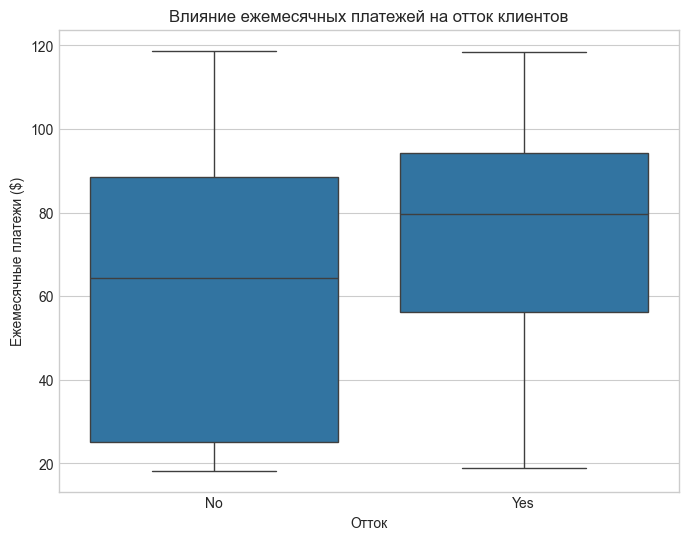


Статистика по ежемесячным платежам:
            mean  median        std
Churn                              
No     61.265124  64.425  31.092648
Yes    74.441332  79.650  24.666053

Проверка гипотезы:
Гипотеза подтверждена: клиенты с оттоком имеют более высокие ежемесячные платежи
Средние платежи ушедших клиентов: $74.44
Средние платежи лояльных клиентов: $61.27
Разница: $13.18


In [9]:
# Задание 4
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='Churn', y='MonthlyCharges')
plt.title('Влияние ежемесячных платежей на отток клиентов')
plt.xlabel('Отток')
plt.ylabel('Ежемесячные платежи ($)')
plt.show()

# Количественный анализ для проверки гипотезы
print("\nСтатистика по ежемесячным платежам:")
monthly_stats = df.groupby('Churn')['MonthlyCharges'].agg(['mean', 'median', 'std'])
print(monthly_stats)

# Проверка гипотезы
print("\nПроверка гипотезы:")
churn_yes_mean = df[df['Churn'] == 'Yes']['MonthlyCharges'].mean()
churn_no_mean = df[df['Churn'] == 'No']['MonthlyCharges'].mean()
difference = churn_yes_mean - churn_no_mean

if churn_yes_mean > churn_no_mean:
    print(f"Гипотеза подтверждена: клиенты с оттоком имеют более высокие ежемесячные платежи")
    print(f"Средние платежи ушедших клиентов: ${churn_yes_mean:.2f}")
    print(f"Средние платежи лояльных клиентов: ${churn_no_mean:.2f}")
    print(f"Разница: ${difference:.2f}")
else:
    print(f"Гипотеза не подтверждена: клиенты с оттоком имеют более низкие ежемесячные платежи")
    print(f"Средние платежи ушедших клиентов: ${churn_yes_mean:.2f}")
    print(f"Средние платежи лояльных клиентов: ${churn_no_mean:.2f}")
    print(f"Разница: ${difference:.2f}")


## Часть 3. Подготовка данных для моделирования (Pre-processing)

Модели машинного обучения работают с числами. Нам нужно преобразовать наши данные: категориальные признаки — в числовые, а числовые — отмасштабировать.

**Задание 5. Предобработка данных**

Выполните следующие шаги:
1. `TotalCharges` имеет тип `object`. Преобразуйте его в числовой с помощью `pd.to_numeric`, а ошибки замените на `NaN` (`errors='coerce'`).
2. Заполните пропуски в `TotalCharges` медианным значением.
3. Целевую переменную `Churn` преобразуйте в 0 и 1.
4. Удалите ненужный для моделирования столбец `customerID`.

In [ ]:
# Задание 5
# 1. Преобразование TotalCharges
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# 2. Заполнение пропусков
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

# 3. Преобразование Churn
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# 4. Удаление customerID
df.drop('customerID', axis=1, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


**Задание 6. Разделение признаков и создание пайплайна**

1. Определите `X` (все столбцы, кроме `Churn`) и `y` (`Churn`).
2. Разделите `X` и `y` на обучающую и тестовую выборки (`train_test_split`) в соотношении 80/20.
3. Определите списки числовых (`numerical_features`) и категориальных (`categorical_features`) признаков.
4. Создайте пайплайн предобработки `preprocessor` с помощью `ColumnTransformer`, который будет масштабировать числовые признаки (`StandardScaler`) и кодировать категориальные (`OneHotEncoder`).

In [11]:
# Задание 6
# 1. Определение X и y
X = df.drop('Churn', axis=1)
y = df['Churn']

# 2. Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Определение типов признаков
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# 4. Создание ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

print("Пайплайн предобработки успешно создан.")

Пайплайн предобработки успешно создан.


## Часть 4. Задача классификации - Прогнозирование оттока

**Задание 7. Обучение модели логистической регрессии**

Создайте пайплайн `log_reg_pipeline`, который последовательно будет выполнять шаги `preprocessor` и обучать модель `LogisticRegression`. Обучите этот пайплайн на `X_train`, `y_train`.

In [12]:
# Задание 7
# Создание пайплайна логистической регрессии
log_reg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Обучение пайплайна
log_reg_pipeline.fit(X_train, y_train)

print("Модель логистической регрессии успешно обучена.")


Модель логистической регрессии успешно обучена.


**Задание 8. Оценка модели и интерпретация для бизнеса**

1. Сделайте предсказания на тестовой выборке (`X_test`).
2. Рассчитайте `accuracy`.
3. Постройте **матрицу ошибок (confusion matrix)** и проинтерпретируйте её с точки зрения бизнеса.

Точность (Accuracy): 0.82


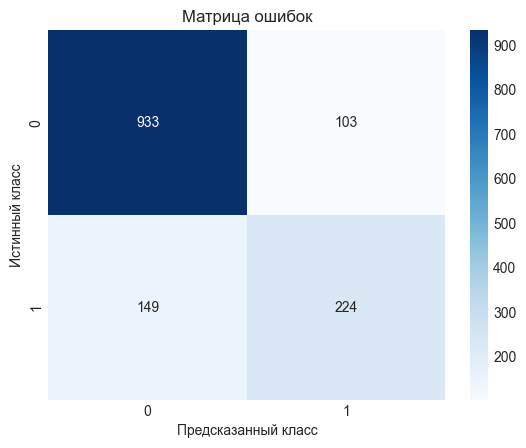

In [15]:
# Задание 8
# 1. Предсказания
y_pred = log_reg_pipeline.predict(X_test)

# 2. Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность (Accuracy): {accuracy:.2f}")

# 3. Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Матрица ошибок')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.show()

# Интерпретация для бизнеса:
# True Negative (TN): 933 - Правильно определены лояльные клиенты
# False Positive (FP): 103 - Ложные тревоги (ошибочно предсказан отток)
# False Negative (FN): 149 - Пропущенные случаи оттока
# True Positive (TP): 224 - Правильно предсказаны случаи оттока

**Задание 9. Анализ важности признаков**

Для линейных моделей, таких как логистическая регрессия, мы можем посмотреть на коэффициенты, чтобы понять, какие признаки наиболее сильно влияют на отток. Извлеките коэффициенты и названия признаков из пайплайна и создайте DataFrame для их анализа.

Топ-10 признаков, влияющих на отток:
                             Признак  Коэффициент  Абсолютное_влияние
1                        num__tenure    -1.327589            1.327589
38            cat__Contract_Two year    -0.829652            0.829652
3                  num__TotalCharges     0.626080            0.626080
36      cat__Contract_Month-to-month     0.596185            0.596185
15          cat__InternetService_DSL    -0.554017            0.554017
16  cat__InternetService_Fiber optic     0.509579            0.509579
2                num__MonthlyCharges    -0.399834            0.399834
39          cat__PaperlessBilling_No    -0.312497            0.312497
12             cat__MultipleLines_No    -0.268753            0.268753
17           cat__InternetService_No    -0.246848            0.246848


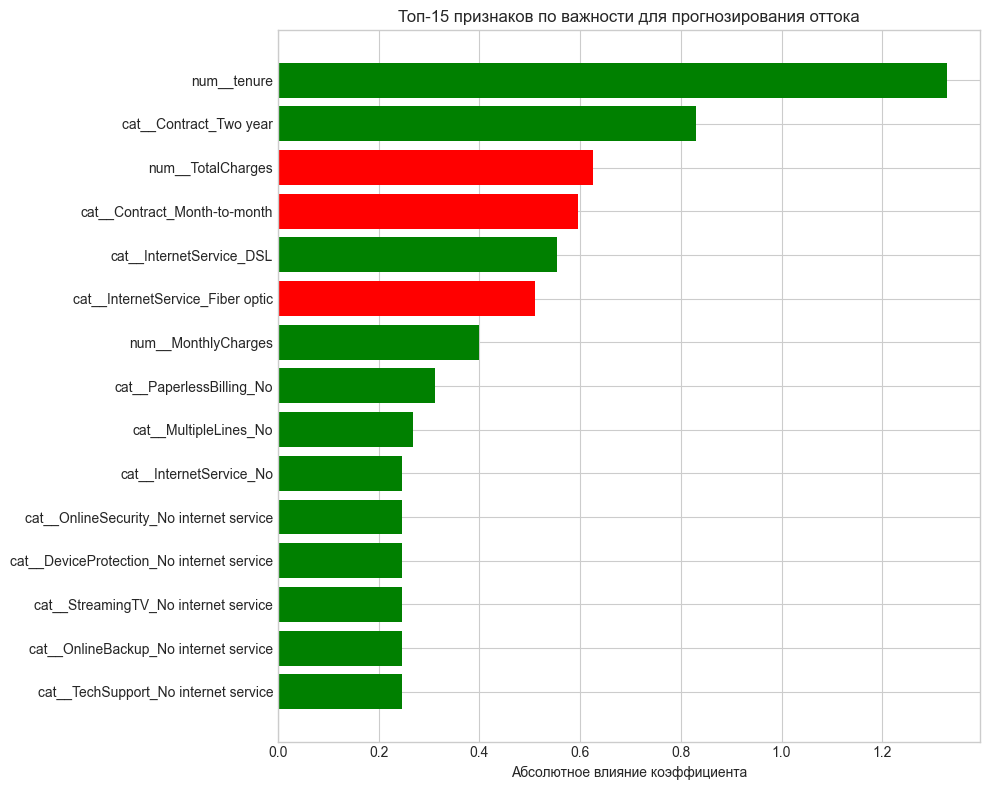


Признаки, УВЕЛИЧИВАЮЩИЕ вероятность оттока (положительные коэффициенты):
                                Признак  Коэффициент
3                     num__TotalCharges     0.626080
36         cat__Contract_Month-to-month     0.596185
16     cat__InternetService_Fiber optic     0.509579
43  cat__PaymentMethod_Electronic check     0.197573
35             cat__StreamingMovies_Yes     0.175611
18               cat__OnlineSecurity_No     0.172022
27                  cat__TechSupport_No     0.130550
32                 cat__StreamingTV_Yes     0.125045
0                    num__SeniorCitizen     0.058832
21                 cat__OnlineBackup_No     0.043217

Признаки, УМЕНЬШАЮЩИЕ вероятность оттока (отрицательные коэффициенты):
                                      Признак  Коэффициент
1                                 num__tenure    -1.327589
38                     cat__Contract_Two year    -0.829652
15                   cat__InternetService_DSL    -0.554017
2                         num__Mont

In [16]:
# Задание 9
# Извлечение через transform и получение имен признаков
preprocessor = log_reg_pipeline.named_steps['preprocessor']
classifier = log_reg_pipeline.named_steps['classifier']

# Получаем названия признаков после трансформации
feature_names = preprocessor.get_feature_names_out()

# Получаем коэффициенты модели
coefficients = classifier.coef_.flatten()

# Создаем DataFrame для анализа
coef_df = pd.DataFrame({
    'Признак': feature_names,
    'Коэффициент': coefficients
})

# Добавляем абсолютное значение для оценки важности
coef_df['Абсолютное_влияние'] = np.abs(coef_df['Коэффициент'])

# Сортируем по абсолютному влиянию
coef_df = coef_df.sort_values(by='Абсолютное_влияние', ascending=False)

# Выводим топ-10 признаков
print("Топ-10 признаков, влияющих на отток:")
print(coef_df[['Признак', 'Коэффициент', 'Абсолютное_влияние']].head(10))

# Визуализация важности признаков
plt.figure(figsize=(10, 8))
top_features = coef_df.head(15)
colors = ['red' if x > 0 else 'green' for x in top_features['Коэффициент']]
plt.barh(range(len(top_features)), top_features['Абсолютное_влияние'], color=colors)
plt.yticks(range(len(top_features)), top_features['Признак'])
plt.xlabel('Абсолютное влияние коэффициента')
plt.title('Топ-15 признаков по важности для прогнозирования оттока')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Раздельный анализ: признаки, увеличивающие и уменьшающие отток
print("\n" + "="*60)
print("Признаки, УВЕЛИЧИВАЮЩИЕ вероятность оттока (положительные коэффициенты):")
increasing_churn = coef_df[coef_df['Коэффициент'] > 0].head(10)
print(increasing_churn[['Признак', 'Коэффициент']])

print("\n" + "="*60)
print("Признаки, УМЕНЬШАЮЩИЕ вероятность оттока (отрицательные коэффициенты):")
decreasing_churn = coef_df[coef_df['Коэффициент'] < 0].head(10)
print(decreasing_churn[['Признак', 'Коэффициент']])


## Часть 5. Задача регрессии - Прогнозирование ценности клиента (LTV)

Не все клиенты одинаково ценны. Прогнозирование **LTV (Lifetime Value)**, или в нашем случае, `TotalCharges` (общие расходы клиента), поможет понять, на удержание каких клиентов стоит тратить больше усилий.

**Задание 10. Подготовка данных для регрессии**

Целевая переменная теперь — `TotalCharges`.
1. Создайте `X_reg` (все столбцы, кроме `TotalCharges` и `customerID`, `Churn`) и `y_reg` (`TotalCharges`).
2. Разделите данные на обучающую и тестовую выборки.

In [17]:
# Задание 10
# Загрузим и очистим данные заново для чистоты эксперимента
df_reg = pd.read_csv(url)
df_reg['TotalCharges'] = pd.to_numeric(df_reg['TotalCharges'], errors='coerce')
df_reg.dropna(inplace=True)

# 1. Определение X и y
X_reg = df_reg.drop(['TotalCharges', 'customerID', 'Churn'], axis=1)
y_reg = df_reg['TotalCharges']

# 2. Разделение на train/test
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

print("Данные для регрессии подготовлены.")
print(f"Размер обучающей выборки: {X_train_reg.shape}")
print(f"Размер тестовой выборки: {X_test_reg.shape}")

Данные для регрессии подготовлены.
Размер обучающей выборки: (5625, 18)
Размер тестовой выборки: (1407, 18)


**Задание 11. Обучение модели линейной регрессии**

Создайте пайплайн для линейной регрессии, который включает `preprocessor` (тот же, что и раньше, но адаптированный под новые `X`) и модель `LinearRegression`. Обучите его.

In [18]:
# Задание 11
# 1. Определение типов признаков для регрессии
numerical_features_reg = X_reg.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features_reg = X_reg.select_dtypes(include=['object']).columns.tolist()

# 2. Создание ColumnTransformer для регрессии
preprocessor_reg = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features_reg),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_reg)
    ])

# 3. Создание пайплайна линейной регрессии
linear_reg_pipeline = Pipeline([
    ('preprocessor', preprocessor_reg),
    ('regressor', LinearRegression())
])

# 4. Обучение пайплайна
linear_reg_pipeline.fit(X_train_reg, y_train_reg)

print("Модель линейной регрессии успешно обучена.")
print(f"Числовые признаки: {numerical_features_reg}")
print(f"Категориальные признаки: {categorical_features_reg}")


Модель линейной регрессии успешно обучена.
Числовые признаки: ['SeniorCitizen', 'tenure', 'MonthlyCharges']
Категориальные признаки: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


**Задание 12. Оценка и интерпретация модели регрессии**

1. Сделайте предсказания на `X_test_reg`.
2. Рассчитайте метрики **RMSE** и **R² (R-squared)**.
3. Визуализируйте результат: постройте диаграмму рассеяния (`scatterplot`), где по одной оси будут реальные значения, а по другой — предсказанные.

RMSE: 673.95
R-squared: 0.91


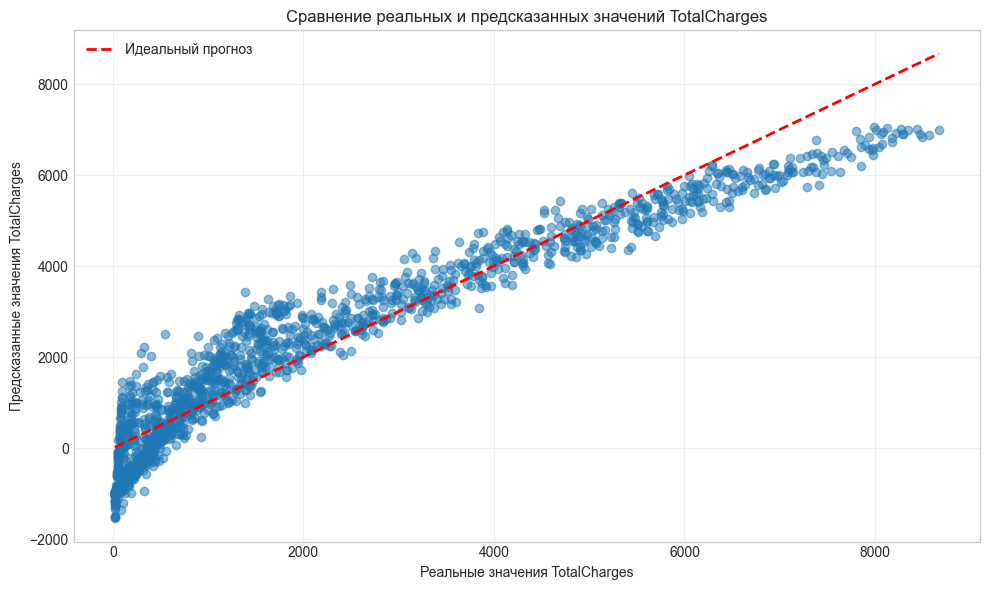

In [19]:
# Задание 12
# 1. Предсказания
y_pred_reg = linear_reg_pipeline.predict(X_test_reg)

# 2. Метрики
rmse_reg = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
r2_reg = r2_score(y_test_reg, y_pred_reg)

print(f"RMSE: {rmse_reg:.2f}")
print(f"R-squared: {r2_reg:.2f}")

# 3. Визуализация
plt.figure(figsize=(10, 6))
plt.scatter(y_test_reg, y_pred_reg, alpha=0.5)
plt.plot([y_test_reg.min(), y_test_reg.max()], 
         [y_test_reg.min(), y_test_reg.max()], 
         'r--', lw=2, label='Идеальный прогноз')
plt.xlabel('Реальные значения TotalCharges')
plt.ylabel('Предсказанные значения TotalCharges')
plt.title('Сравнение реальных и предсказанных значений TotalCharges')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Бизнес-интерпретация:
# RMSE показывает среднюю ошибку прогноза в долларах. R² показывает, какую долю дисперсии целевой переменной объясняет наша модель.
# На графике идеальный прогноз лежал бы на диагональной линии. Мы видим, что модель в целом улавливает тренд, но имеет заметную ошибку.

## Часть 6. Комплексное бизнес-решение

Теперь объединим результаты обеих моделей для принятия взвешенного решения.

**Задание 13. Создание финального DataFrame с прогнозами**

Сделайте предсказания обеими моделями на всем датасете и добавьте их как новые столбцы: `churn_probability` (вероятность оттока) и `predicted_ltv`.

In [21]:
# Задание 13
# Подготовка данных для предсказаний на всем датасете

# Для классификации нужен X (без Churn, customerID)
df_for_classification = df_reg.copy()
# Преобразуем Churn в 0/1
if df_for_classification['Churn'].dtype == 'object':
    df_for_classification['Churn'] = df_for_classification['Churn'].map({'Yes': 1, 'No': 0})
X_full = df_for_classification.drop(['Churn', 'customerID'], axis=1)

# Для регрессии нужен X_reg (без TotalCharges, customerID, Churn)
X_full_reg = df_reg.drop(['TotalCharges', 'customerID', 'Churn'], axis=1)

# Предсказания моделью классификации (вероятность оттока)
# Используем predict_proba для получения вероятности класса 1 (отток)
churn_probabilities = log_reg_pipeline.predict_proba(X_full)[:, 1]

# Предсказания моделью регрессии (прогнозируемая ценность клиента)
predicted_ltv = linear_reg_pipeline.predict(X_full_reg)

# Создание финального DataFrame
# Используем df_reg, так как он содержит customerID и все необходимые столбцы
df_final = df_reg.copy()

# Добавление столбцов с прогнозами
df_final['churn_probability'] = churn_probabilities
df_final['predicted_ltv'] = predicted_ltv

print("Финальный DataFrame создан.")
print(f"Размер DataFrame: {df_final.shape}")
print(f"\nПервые 5 строк с прогнозами:")
display(df_final[['customerID', 'Churn', 'churn_probability', 'predicted_ltv', 'TotalCharges']].head())
print(f"\nСтатистика по вероятности оттока:")
print(df_final['churn_probability'].describe())
print(f"\nСтатистика по прогнозируемой ценности:")
print(df_final['predicted_ltv'].describe())


Финальный DataFrame создан.
Размер DataFrame: (7032, 23)

Первые 5 строк с прогнозами:


,customerID,Churn,churn_probability,predicted_ltv,TotalCharges
0,7590-VHVEG,No,0.647682,-1029.111908,29.85
1,5575-GNVDE,No,0.043229,2241.371627,1889.50
2,3668-QPYBK,Yes,0.273899,278.429079,108.15
3,7795-CFOCW,No,0.032175,2491.085068,1840.75
4,9237-HQITU,Yes,0.689719,63.498266,151.65



Статистика по вероятности оттока:
count    7032.000000
mean        0.266546
std         0.241070
min         0.001518
25%         0.045520
50%         0.196647
75%         0.460592
max         0.841670
Name: churn_probability, dtype: float64

Статистика по прогнозируемой ценности:
count    7032.000000
mean     2281.692455
std      2156.370371
min     -1552.253267
25%       504.202952
50%      2054.309452
75%      3949.139532
max      7268.714524
Name: predicted_ltv, dtype: float64


**Задание 14. Сегментация клиентов для принятия решений**

**Бизнес-задача.** Нам нужно выделить сегмент клиентов, на удержание которых стоит потратить ресурсы в первую очередь.
**Критерии.**
1. Высокая вероятность оттока (`churn_probability > 0.6`).
2. Высокая прогнозируемая ценность (`predicted_ltv` выше 75-го перцентиля).

Отфильтруйте `df_final` по этим двум критериям и выведите результат.

In [24]:
# Задание 14
# Вычисление 75-го перцентиля для predicted_ltv
ltv_75th_percentile = df_final['predicted_ltv'].quantile(0.75)

print("Критерии для сегментации:")
print(f"1. Вероятность оттока > 0.6")
print(f"2. Прогнозируемая ценность > {ltv_75th_percentile:.2f} (75-й перцентиль)")
print(f"\n75-й перцентиль predicted_ltv: {ltv_75th_percentile:.2f}")

# Фильтрация клиентов по критериям
high_priority_clients = df_final[
    (df_final['churn_probability'] > 0.6) & 
    (df_final['predicted_ltv'] > ltv_75th_percentile)
].copy()

print(f"\nКоличество клиентов в приоритетном сегменте: {len(high_priority_clients)}")
print(f"Процент от общего числа клиентов: {len(high_priority_clients) / len(df_final) * 100:.2f}%")

# Вывод результатов
print("\n" + "="*80)
print("ПРИОРИТЕТНЫЙ СЕГМЕНТ КЛИЕНТОВ ДЛЯ УДЕРЖАНИЯ")
print("="*80)
print(f"\nВсего клиентов в сегменте: {len(high_priority_clients)}")

# Вывод основных столбцов
display(high_priority_clients[['customerID', 'Churn', 'churn_probability', 
                                'predicted_ltv', 'TotalCharges', 'MonthlyCharges', 
                                'tenure', 'Contract']].head(20))

# Статистика по приоритетному сегменту
print("\n" + "="*80)
print("СТАТИСТИКА ПО ПРИОРИТЕТНОМУ СЕГМЕНТУ")
print("="*80)
print("\nСредняя вероятность оттока:")
print(f"  {high_priority_clients['churn_probability'].mean():.3f}")

print("\nСредняя прогнозируемая ценность (LTV):")
print(f"  ${high_priority_clients['predicted_ltv'].mean():.2f}")

print("\nСредняя фактическая ценность (TotalCharges):")
print(f"  ${high_priority_clients['TotalCharges'].mean():.2f}")

print("\nРаспределение по типам контрактов:")
print(high_priority_clients['Contract'].value_counts())

Критерии для сегментации:
1. Вероятность оттока > 0.6
2. Прогнозируемая ценность > 3949.14 (75-й перцентиль)

75-й перцентиль predicted_ltv: 3949.14

Количество клиентов в приоритетном сегменте: 7
Процент от общего числа клиентов: 0.10%

ПРИОРИТЕТНЫЙ СЕГМЕНТ КЛИЕНТОВ ДЛЯ УДЕРЖАНИЯ

Всего клиентов в сегменте: 7


,customerID,Churn,churn_probability,predicted_ltv,TotalCharges,MonthlyCharges,tenure,Contract
574,6030-REHUX,No,0.620474,4028.121032,3204.40,110.85,28,Month-to-month
1081,1751-NCDLI,No,0.606938,4238.582650,4564.90,98.85,46,Month-to-month
1125,8111-SLLHI,Yes,0.626256,4328.027694,4284.80,105.65,39,Month-to-month
1630,2439-LYPMQ,No,0.630596,4164.662100,4009.20,102.60,38,Month-to-month
2948,2845-AFFTX,Yes,0.647717,3966.143035,4259.30,99.80,41,Month-to-month
3681,4433-JCGCG,Yes,0.607728,4310.831721,4680.05,101.00,46,Month-to-month
6453,8634-MPHTR,Yes,0.610382,4339.780438,4871.05,100.05,47,Month-to-month



СТАТИСТИКА ПО ПРИОРИТЕТНОМУ СЕГМЕНТУ

Средняя вероятность оттока:
  0.621

Средняя прогнозируемая ценность (LTV):
  $4196.59

Средняя фактическая ценность (TotalCharges):
  $4267.67

Распределение по типам контрактов:
Contract
Month-to-month    7
Name: count, dtype: int64


---

## Часть 7. Индивидуальный проект - "Построение и оценка модели для прогнозирования оттока клиентов"

**Цель:** Самостоятельно провести полный цикл построения модели оттока для выбранной предметной области, используя знания, полученные в ходе выполнения лабораторной работы.

### Инструкция
1.  **Выберите ваш вариант** из списка ниже.
2.  **Найдите подходящий датасет на Kaggle.** Используйте ключевые слова из вашего варианта (например, `e-commerce customer churn`, `banking churn dataset`). Датасет должен содержать целевую переменную (факт оттока) и не менее 5-7 признаков.
3.  **Проведите полный цикл анализа**, аналогичный тому, что был выполнен в этой тетради:
    *   Загрузка и первичный осмотр данных.
    *   Исследовательский анализ (EDA) с построением 2-3 гипотез и их визуальной проверкой.
    *   Предобработка данных (обработка пропусков, кодирование категорий, масштабирование).
    *   Разделение на обучающую и тестовую выборки.
    *   Построение модели классификации (например, `LogisticRegression` или `RandomForestClassifier`).
    *   Оценка модели (accuracy, confusion matrix) и **интерпретация результатов с точки зрения бизнеса**.
4.  Оформите ваше решение в виде Jupyter Notebook, сохранив все выводы и графики.

## Индивидуальный проект: Прогнозирование увольнения сотрудников (HR-аналитика)

**Вариант 19:** HR-аналитика. Прогнозирование увольнения сотрудников (внутренний отток).

**Датасет:** employee_data.csv

В данном проекте мы проведем полный цикл анализа данных для прогнозирования оттока сотрудников, используя методы машинного обучения.

### Шаг 1. Загрузка и первичный осмотр данных

На первом этапе загрузим датасет и проведем первичный осмотр данных: посмотрим на структуру, типы данных, наличие пропусков и основные статистики.


In [2]:
# Загрузка данных
df_hr = pd.read_csv('employee_data.csv')

# Первичный осмотр данных
print("="*80)
print("ПЕРВИЧНЫЙ ОСМОТР ДАННЫХ")
print("="*80)

print(f"\nРазмер датасета: {df_hr.shape[0]} строк, {df_hr.shape[1]} столбцов")

print("\nПервые 5 строк датасета:")
display(df_hr.head())

print("\nИнформация о датасете:")
df_hr.info()

print("\nСтатистическое описание числовых признаков:")
display(df_hr.describe())

print("\nПроверка пропусков:")
missing_data = df_hr.isnull().sum()
missing_percent = (missing_data / len(df_hr)) * 100
missing_df = pd.DataFrame({
    'Количество пропусков': missing_data,
    'Процент пропусков': missing_percent
})
missing_df = missing_df[missing_df['Количество пропусков'] > 0].sort_values('Количество пропусков', ascending=False)
if len(missing_df) > 0:
    display(missing_df)
else:
    print("Пропусков в данных не обнаружено.")

# Создание целевой переменной на основе ExitDate
df_hr['Churn'] = df_hr['ExitDate'].notna().astype(int)

print("\n" + "="*80)
print("АНАЛИЗ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ (Churn)")
print("="*80)
print("\nРаспределение оттока сотрудников:")
churn_dist = df_hr['Churn'].value_counts()
print(churn_dist)
print(f"\nПроцентное соотношение:")
churn_percent = df_hr['Churn'].value_counts(normalize=True) * 100
print(churn_percent)


ПЕРВИЧНЫЙ ОСМОТР ДАННЫХ

Размер датасета: 3000 строк, 26 столбцов

Первые 5 строк датасета:


,EmpID,FirstName,LastName,StartDate,ExitDate,Title,Supervisor,ADEmail,BusinessUnit,EmployeeStatus,EmployeeType,PayZone,EmployeeClassificationType,TerminationType,TerminationDescription,DepartmentType,Division,DOB,State,JobFunctionDescription,GenderCode,LocationCode,RaceDesc,MaritalDesc,Performance Score,Current Employee Rating
0,3427,Uriah,Bridges,20-Sep-19,NaN,Production Technician I,Peter Oneill,uriah.bridges@bilearner.com,CCDR,Active,Contract,Zone C,Temporary,Unk,NaN,Production,Finance & Accounting,07-10-1969,MA,Accounting,Female,34904,White,Widowed,Fully Meets,4
1,3428,Paula,Small,11-Feb-23,NaN,Production Technician I,Renee Mccormick,paula.small@bilearner.com,EW,Active,Contract,Zone A,Part-Time,Unk,NaN,Production,Aerial,30-08-1965,MA,Labor,Male,6593,Hispanic,Widowed,Fully Meets,3
2,3429,Edward,Buck,10-Dec-18,NaN,Area Sales Manager,Crystal Walker,edward.buck@bilearner.com,PL,Active,Full-Time,Zone B,Part-Time,Unk,NaN,Sales,General - Sga,06-10-1991,MA,Assistant,Male,2330,Hispanic,Widowed,Fully Meets,4
3,3430,Michael,Riordan,21-Jun-21,NaN,Area Sales Manager,Rebekah Wright,michael.riordan@bilearner.com,CCDR,Active,Contract,Zone A,Full-Time,Unk,NaN,Sales,Finance & Accounting,04-04-1998,ND,Clerk,Male,58782,Other,Single,Fully Meets,2
4,3431,Jasmine,Onque,29-Jun-19,NaN,Area Sales Manager,Jason Kim,jasmine.onque@bilearner.com,TNS,Active,Contract,Zone A,Temporary,Unk,NaN,Sales,General - Con,29-08-1969,FL,Laborer,Female,33174,Other,Married,Fully Meets,3



Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   EmpID                       3000 non-null   int64 
 1   FirstName                   3000 non-null   object
 2   LastName                    3000 non-null   object
 3   StartDate                   3000 non-null   object
 4   ExitDate                    1533 non-null   object
 5   Title                       3000 non-null   object
 6   Supervisor                  3000 non-null   object
 7   ADEmail                     3000 non-null   object
 8   BusinessUnit                3000 non-null   object
 9   EmployeeStatus              3000 non-null   object
 10  EmployeeType                3000 non-null   object
 11  PayZone                     3000 non-null   object
 12  EmployeeClassificationType  3000 non-null   object
 13  TerminationType         

,EmpID,LocationCode,Current Employee Rating
count,3000.000000,3000.000000,3000.000000
mean,2500.500000,44997.180667,2.969000
std,866.169729,29987.331783,1.015078
min,1001.000000,1013.000000,1.000000
25%,1750.750000,17546.000000,2.000000
50%,2500.500000,44150.500000,3.000000
75%,3250.250000,71481.250000,3.000000
max,4000.000000,98052.000000,5.000000



Проверка пропусков:


,Количество пропусков,Процент пропусков
ExitDate,1467,48.9
TerminationDescription,1467,48.9



АНАЛИЗ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ (Churn)

Распределение оттока сотрудников:
Churn
1    1533
0    1467
Name: count, dtype: int64

Процентное соотношение:
Churn
1    51.1
0    48.9
Name: proportion, dtype: float64


### Шаг 2. Исследовательский анализ данных (EDA) с проверкой гипотез

Проведем исследовательский анализ данных для понимания факторов, влияющих на отток сотрудников. Сформулируем и проверим несколько бизнес-гипотез:

1. **Гипотеза 1:** Сотрудники с низкими оценками производительности чаще увольняются.
2. **Гипотеза 2:** Сотрудники с временным типом занятости (Temporary/Contract) имеют более высокий риск оттока.
3. **Гипотеза 3:** Сотрудники с более низким рейтингом (Current Employee Rating) чаще увольняются.


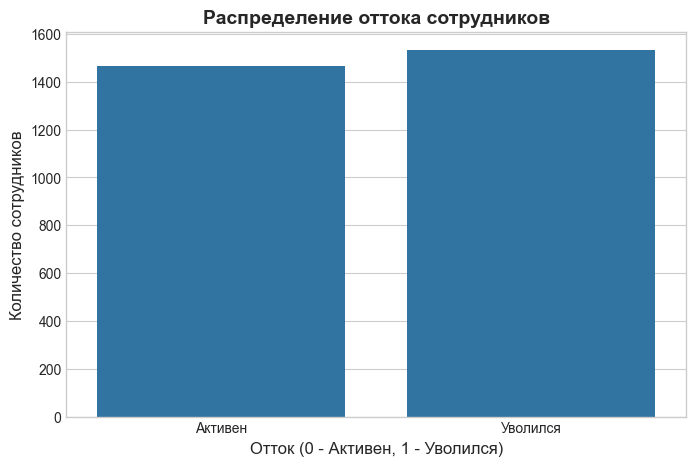

Распределение классов:
Churn
1    1533
0    1467
Name: count, dtype: int64

Процентное соотношение:
Churn
1    51.1
0    48.9
Name: proportion, dtype: float64


In [3]:
# Визуализация распределения целевой переменной
plt.figure(figsize=(8, 5))
sns.countplot(data=df_hr, x='Churn')
plt.title('Распределение оттока сотрудников', fontsize=14, fontweight='bold')
plt.xlabel('Отток (0 - Активен, 1 - Уволился)', fontsize=12)
plt.ylabel('Количество сотрудников', fontsize=12)
plt.xticks([0, 1], ['Активен', 'Уволился'])
plt.show()

print("Распределение классов:")
print(df_hr['Churn'].value_counts())
print("\nПроцентное соотношение:")
print(df_hr['Churn'].value_counts(normalize=True) * 100)


#### Гипотеза 1: Влияние оценки производительности на отток

Проверим, действительно ли сотрудники с низкими оценками производительности ("Needs Improvement") чаще увольняются.


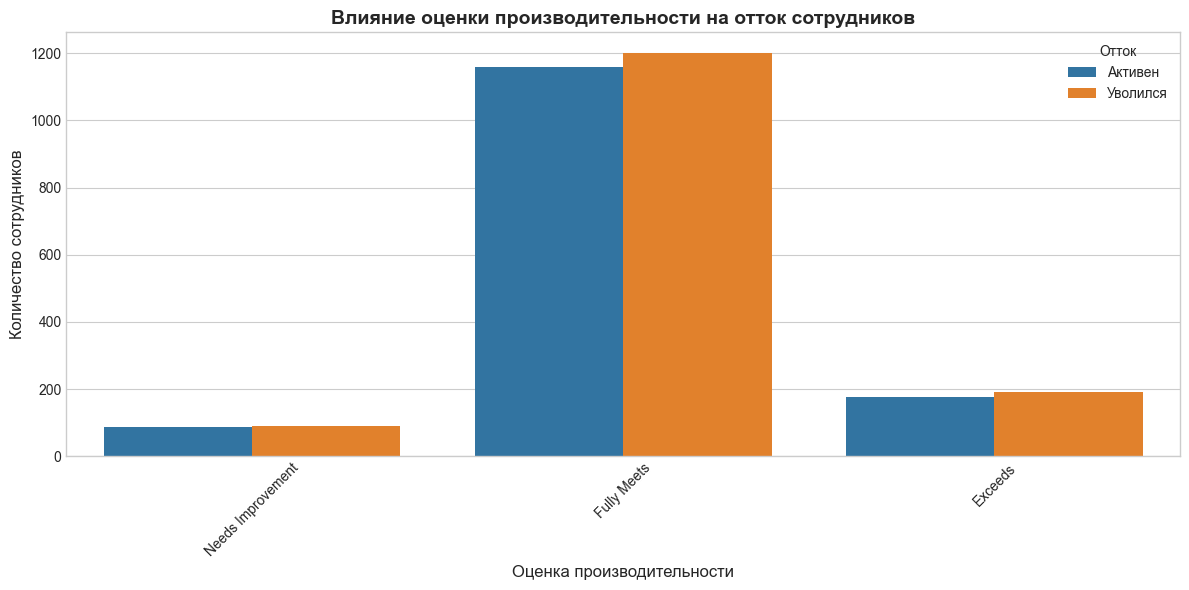


АНАЛИЗ ВЛИЯНИЯ ОЦЕНКИ ПРОИЗВОДИТЕЛЬНОСТИ НА ОТТОК

Распределение оттока по оценкам производительности (%):


Churn,0,1
Performance Score,,
Exceeds,48.238482,51.761518
Fully Meets,49.089369,50.910631
Needs Improvement,48.587571,51.412429
PIP,47.311828,52.688172



Процент оттока по оценкам производительности:
Performance Score
PIP                  52.688172
Exceeds              51.761518
Needs Improvement    51.412429
Fully Meets          50.910631
Name: Churn, dtype: float64

ПРОВЕРКА ГИПОТЕЗЫ 1:
Гипотеза НЕ подтверждена: Сотрудники с оценкой 'Needs Improvement' имеют процент оттока 51.4%
что не выше среднего по другим оценкам (51.8%)


In [4]:
# Гипотеза 1: Влияние оценки производительности на отток
plt.figure(figsize=(12, 6))
sns.countplot(data=df_hr, x='Performance Score', hue='Churn', order=['Needs Improvement', 'Fully Meets', 'Exceeds'])
plt.title('Влияние оценки производительности на отток сотрудников', fontsize=14, fontweight='bold')
plt.xlabel('Оценка производительности', fontsize=12)
plt.ylabel('Количество сотрудников', fontsize=12)
plt.legend(title='Отток', labels=['Активен', 'Уволился'], loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Количественный анализ
print("\n" + "="*60)
print("АНАЛИЗ ВЛИЯНИЯ ОЦЕНКИ ПРОИЗВОДИТЕЛЬНОСТИ НА ОТТОК")
print("="*60)
performance_churn = pd.crosstab(df_hr['Performance Score'], df_hr['Churn'], normalize='index') * 100
print("\nРаспределение оттока по оценкам производительности (%):")
display(performance_churn)

print("\nПроцент оттока по оценкам производительности:")
churn_by_performance = df_hr.groupby('Performance Score')['Churn'].apply(lambda x: (x == 1).sum() / len(x) * 100)
print(churn_by_performance.sort_values(ascending=False))

# Проверка гипотезы
print("\n" + "="*60)
print("ПРОВЕРКА ГИПОТЕЗЫ 1:")
print("="*60)
if 'Needs Improvement' in churn_by_performance.index:
    needs_improvement_churn = churn_by_performance['Needs Improvement']
    other_scores_churn = churn_by_performance[churn_by_performance.index != 'Needs Improvement'].mean()
    
    if needs_improvement_churn > other_scores_churn:
        print(f"Гипотеза ПОДТВЕРЖДЕНА: Сотрудники с оценкой 'Needs Improvement' имеют более высокий процент оттока ({needs_improvement_churn:.1f}%)")
        print(f"по сравнению со средним по другим оценкам ({other_scores_churn:.1f}%)")
    else:
        print(f"Гипотеза НЕ подтверждена: Сотрудники с оценкой 'Needs Improvement' имеют процент оттока {needs_improvement_churn:.1f}%")
        print(f"что не выше среднего по другим оценкам ({other_scores_churn:.1f}%)")


#### Гипотеза 2: Влияние типа занятости на отток

Проверим, действительно ли сотрудники с временным типом занятости (Temporary/Contract) имеют более высокий риск оттока по сравнению с постоянными сотрудниками (Full-Time).


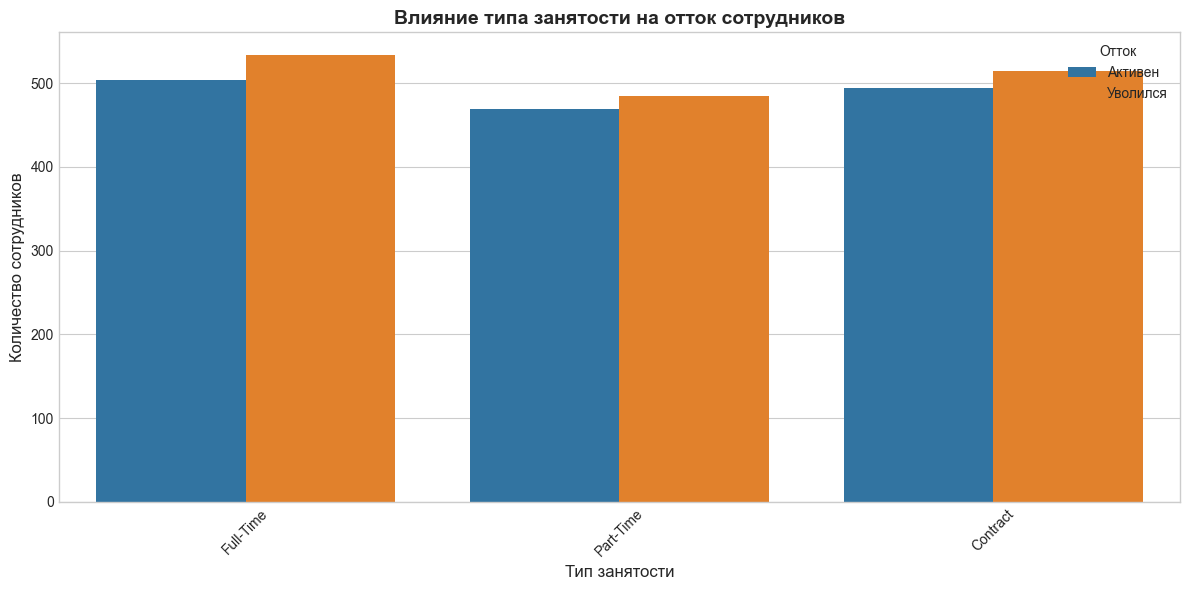


АНАЛИЗ ВЛИЯНИЯ ТИПА ЗАНЯТОСТИ НА ОТТОК

Распределение оттока по типам занятости (%):


Churn,0,1
EmployeeType,,
Contract,49.007937,50.992063
Full-Time,48.554913,51.445087
Part-Time,49.161426,50.838574



Процент оттока по типам занятости:
EmployeeType
Full-Time    51.445087
Contract     50.992063
Part-Time    50.838574
Name: Churn, dtype: float64

ПРОВЕРКА ГИПОТЕЗЫ 2:
Гипотеза НЕ подтверждена: Сотрудники с временным типом занятости имеют процент оттока 51.0%
что не выше, чем у постоянных сотрудников (51.4%)


In [5]:
# Гипотеза 2: Влияние типа занятости на отток
plt.figure(figsize=(12, 6))
sns.countplot(data=df_hr, x='EmployeeType', hue='Churn', order=['Full-Time', 'Part-Time', 'Contract'])
plt.title('Влияние типа занятости на отток сотрудников', fontsize=14, fontweight='bold')
plt.xlabel('Тип занятости', fontsize=12)
plt.ylabel('Количество сотрудников', fontsize=12)
plt.legend(title='Отток', labels=['Активен', 'Уволился'], loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Количественный анализ
print("\n" + "="*60)
print("АНАЛИЗ ВЛИЯНИЯ ТИПА ЗАНЯТОСТИ НА ОТТОК")
print("="*60)
employment_churn = pd.crosstab(df_hr['EmployeeType'], df_hr['Churn'], normalize='index') * 100
print("\nРаспределение оттока по типам занятости (%):")
display(employment_churn)

print("\nПроцент оттока по типам занятости:")
churn_by_employment = df_hr.groupby('EmployeeType')['Churn'].apply(lambda x: (x == 1).sum() / len(x) * 100)
print(churn_by_employment.sort_values(ascending=False))

# Проверка гипотезы
print("\n" + "="*60)
print("ПРОВЕРКА ГИПОТЕЗЫ 2:")
print("="*60)
temporary_types = ['Contract', 'Temporary']
full_time_churn = churn_by_employment.get('Full-Time', 0)
temporary_churn = churn_by_employment[churn_by_employment.index.isin(temporary_types)].mean() if any(x in churn_by_employment.index for x in temporary_types) else 0

if temporary_churn > full_time_churn:
    print(f"Гипотеза ПОДТВЕРЖДЕНА: Сотрудники с временным типом занятости имеют более высокий процент оттока ({temporary_churn:.1f}%)")
    print(f"по сравнению с постоянными сотрудниками ({full_time_churn:.1f}%)")
else:
    print(f"Гипотеза НЕ подтверждена: Сотрудники с временным типом занятости имеют процент оттока {temporary_churn:.1f}%")
    print(f"что не выше, чем у постоянных сотрудников ({full_time_churn:.1f}%)")


#### Гипотеза 3: Влияние текущего рейтинга сотрудника на отток

Проверим, действительно ли сотрудники с более низким рейтингом (Current Employee Rating) чаще увольняются.


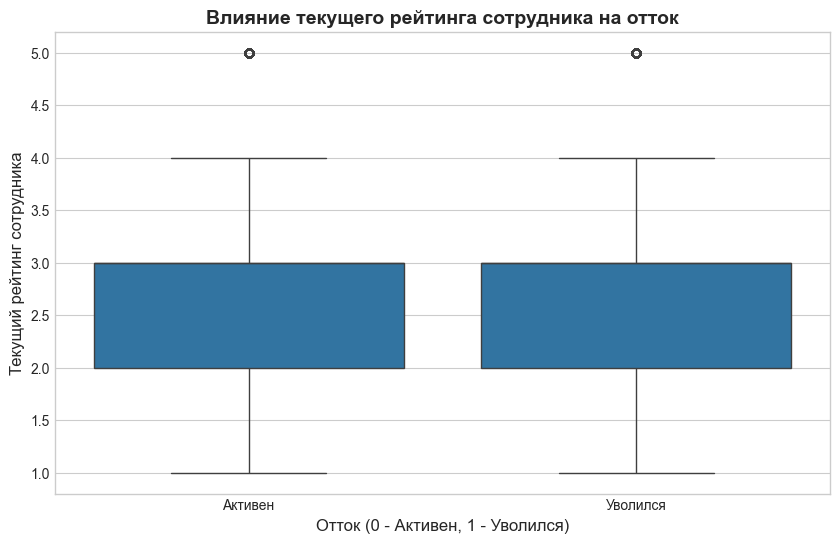


АНАЛИЗ ВЛИЯНИЯ ТЕКУЩЕГО РЕЙТИНГА НА ОТТОК

Статистика по текущему рейтингу:


,mean,median,std
Churn,,,
0,2.961145,3.0,1.021189
1,2.976517,3.0,1.009470



ПРОВЕРКА ГИПОТЕЗЫ 3:
Гипотеза НЕ подтверждена: Уволившиеся сотрудники имеют более высокий средний рейтинг
Средний рейтинг уволившихся: 2.98
Средний рейтинг активных: 2.96
Разница: -0.02


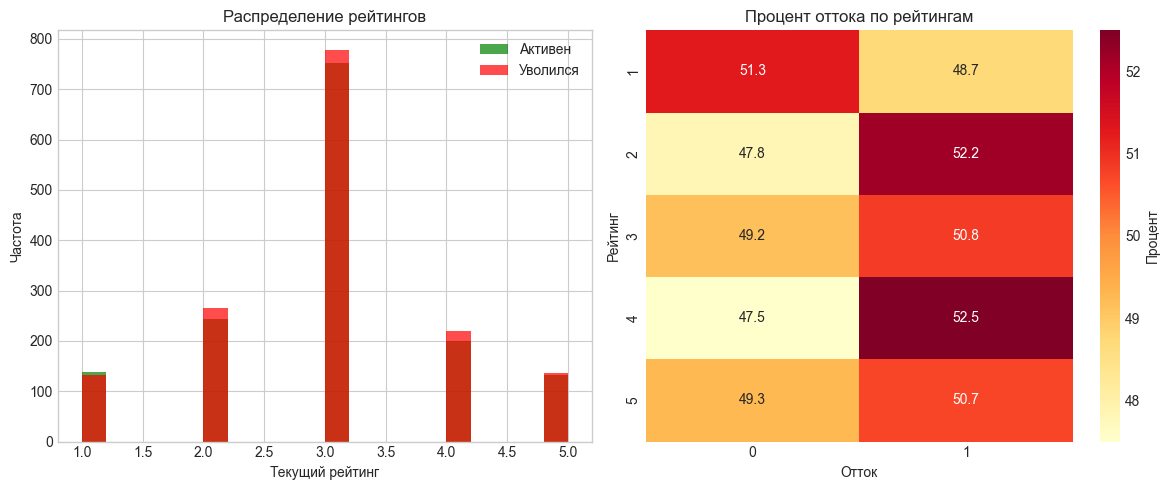

In [6]:
# Гипотеза 3: Влияние текущего рейтинга на отток
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_hr, x='Churn', y='Current Employee Rating')
plt.title('Влияние текущего рейтинга сотрудника на отток', fontsize=14, fontweight='bold')
plt.xlabel('Отток (0 - Активен, 1 - Уволился)', fontsize=12)
plt.ylabel('Текущий рейтинг сотрудника', fontsize=12)
plt.xticks([0, 1], ['Активен', 'Уволился'])
plt.show()

# Количественный анализ
print("\n" + "="*60)
print("АНАЛИЗ ВЛИЯНИЯ ТЕКУЩЕГО РЕЙТИНГА НА ОТТОК")
print("="*60)
rating_stats = df_hr.groupby('Churn')['Current Employee Rating'].agg(['mean', 'median', 'std'])
print("\nСтатистика по текущему рейтингу:")
display(rating_stats)

# Проверка гипотезы
print("\n" + "="*60)
print("ПРОВЕРКА ГИПОТЕЗЫ 3:")
print("="*60)
churn_yes_rating = df_hr[df_hr['Churn'] == 1]['Current Employee Rating'].mean()
churn_no_rating = df_hr[df_hr['Churn'] == 0]['Current Employee Rating'].mean()
difference = churn_no_rating - churn_yes_rating

if churn_yes_rating < churn_no_rating:
    print(f"Гипотеза ПОДТВЕРЖДЕНА: Уволившиеся сотрудники имеют более низкий средний рейтинг")
    print(f"Средний рейтинг уволившихся: {churn_yes_rating:.2f}")
    print(f"Средний рейтинг активных: {churn_no_rating:.2f}")
    print(f"Разница: {difference:.2f}")
else:
    print(f"Гипотеза НЕ подтверждена: Уволившиеся сотрудники имеют более высокий средний рейтинг")
    print(f"Средний рейтинг уволившихся: {churn_yes_rating:.2f}")
    print(f"Средний рейтинг активных: {churn_no_rating:.2f}")
    print(f"Разница: {difference:.2f}")

# Дополнительная визуализация распределения рейтингов
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
df_hr[df_hr['Churn'] == 0]['Current Employee Rating'].hist(bins=20, alpha=0.7, label='Активен', color='green')
df_hr[df_hr['Churn'] == 1]['Current Employee Rating'].hist(bins=20, alpha=0.7, label='Уволился', color='red')
plt.xlabel('Текущий рейтинг')
plt.ylabel('Частота')
plt.title('Распределение рейтингов')
plt.legend()

plt.subplot(1, 2, 2)
rating_churn = pd.crosstab(df_hr['Current Employee Rating'], df_hr['Churn'], normalize='index') * 100
sns.heatmap(rating_churn, annot=True, fmt='.1f', cmap='YlOrRd', cbar_kws={'label': 'Процент'})
plt.title('Процент оттока по рейтингам')
plt.xlabel('Отток')
plt.ylabel('Рейтинг')
plt.tight_layout()
plt.show()


### Шаг 3. Предобработка данных

На этом этапе подготовим данные для моделирования:
1. Обработаем пропуски в данных
2. Создадим дополнительные полезные признаки (например, стаж работы)
3. Выберем признаки для моделирования
4. Подготовим данные для кодирования категориальных признаков и масштабирования числовых


In [7]:
# Создаем копию датасета для предобработки
df_model = df_hr.copy()

# 1. Обработка дат и создание признака стажа работы
from datetime import datetime

# Преобразуем даты в формат datetime
df_model['StartDate'] = pd.to_datetime(df_model['StartDate'], format='%d-%b-%y', errors='coerce')
df_model['ExitDate'] = pd.to_datetime(df_model['ExitDate'], format='%d-%b-%y', errors='coerce')

# Создаем признак стажа работы (в днях)
# Для уволившихся: стаж = ExitDate - StartDate
# Для активных: стаж = текущая дата (или максимальная дата в датасете) - StartDate
max_date = df_model['StartDate'].max()  # Используем максимальную дату как "текущую"
df_model['Tenure_Days'] = df_model.apply(
    lambda row: (row['ExitDate'] - row['StartDate']).days if pd.notna(row['ExitDate']) 
    else (max_date - row['StartDate']).days, axis=1
)

# Преобразуем в месяцы для удобства
df_model['Tenure_Months'] = df_model['Tenure_Days'] / 30.44

# 2. Обработка пропусков
print("="*80)
print("ОБРАБОТКА ПРОПУСКОВ")
print("="*80)

# Проверяем пропуски после преобразования дат
print("\nПропуски после преобразования дат:")
missing_after = df_model[['StartDate', 'ExitDate', 'Tenure_Days', 'Tenure_Months']].isnull().sum()
print(missing_after[missing_after > 0])

# Заполняем пропуски в Tenure_Months медианным значением
if df_model['Tenure_Months'].isnull().sum() > 0:
    median_tenure = df_model['Tenure_Months'].median()
    df_model['Tenure_Months'].fillna(median_tenure, inplace=True)
    print(f"\nЗаполнено {df_model['Tenure_Months'].isnull().sum()} пропусков в Tenure_Months медианным значением: {median_tenure:.2f} месяцев")

# 3. Выбор признаков для моделирования
# Исключаем идентификаторы и текстовые описания
features_to_drop = [
    'EmpID', 'FirstName', 'LastName', 'ADEmail', 'Supervisor', 
    'StartDate', 'ExitDate', 'TerminationDescription', 'DOB'
]

# Оставляем только полезные признаки
features_to_keep = [
    'BusinessUnit', 'EmployeeType', 'PayZone', 'EmployeeClassificationType',
    'DepartmentType', 'Division', 'State', 'JobFunctionDescription', 
    'GenderCode', 'RaceDesc', 'MaritalDesc', 'Performance Score',
    'Title', 'Current Employee Rating', 'LocationCode', 'Tenure_Months'
]

# Создаем финальный датасет для моделирования
df_final = df_model[features_to_keep + ['Churn']].copy()

print("\n" + "="*80)
print("ФИНАЛЬНЫЙ НАБОР ПРИЗНАКОВ ДЛЯ МОДЕЛИРОВАНИЯ")
print("="*80)
print(f"\nКоличество признаков: {len(features_to_keep)}")
print(f"Размер датасета: {df_final.shape}")
print(f"\nСписок признаков:")
for i, feature in enumerate(features_to_keep, 1):
    print(f"{i}. {feature}")

# Проверяем финальные пропуски
print("\n" + "="*80)
print("ПРОВЕРКА ПРОПУСКОВ В ФИНАЛЬНОМ ДАТАСЕТЕ")
print("="*80)
final_missing = df_final.isnull().sum()
if final_missing.sum() > 0:
    print("\nОбнаружены пропуски:")
    print(final_missing[final_missing > 0])
    # Заполняем пропуски в категориальных признаках модой
    for col in df_final.select_dtypes(include=['object']).columns:
        if df_final[col].isnull().sum() > 0:
            mode_value = df_final[col].mode()[0] if len(df_final[col].mode()) > 0 else 'Unknown'
            df_final[col].fillna(mode_value, inplace=True)
            print(f"Заполнено {col} значением: {mode_value}")
else:
    print("\n✓ Пропусков не обнаружено")

print("\nИнформация о финальном датасете:")
df_final.info()


ОБРАБОТКА ПРОПУСКОВ

Пропуски после преобразования дат:
ExitDate    1467
dtype: int64

ФИНАЛЬНЫЙ НАБОР ПРИЗНАКОВ ДЛЯ МОДЕЛИРОВАНИЯ

Количество признаков: 16
Размер датасета: (3000, 17)

Список признаков:
1. BusinessUnit
2. EmployeeType
3. PayZone
4. EmployeeClassificationType
5. DepartmentType
6. Division
7. State
8. JobFunctionDescription
9. GenderCode
10. RaceDesc
11. MaritalDesc
12. Performance Score
13. Title
14. Current Employee Rating
15. LocationCode
16. Tenure_Months

ПРОВЕРКА ПРОПУСКОВ В ФИНАЛЬНОМ ДАТАСЕТЕ

✓ Пропусков не обнаружено

Информация о финальном датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   BusinessUnit                3000 non-null   object 
 1   EmployeeType                3000 non-null   object 
 2   PayZone                     3000 non-null   object 
 3   EmployeeClassificatio

### Шаг 4. Разделение на обучающую и тестовую выборки

Разделим данные на обучающую (80%) и тестовую (20%) выборки для обучения и оценки модели.


In [9]:
# Разделение признаков и целевой переменной
X = df_final.drop('Churn', axis=1)
y = df_final['Churn']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("="*80)
print("РАЗДЕЛЕНИЕ ДАННЫХ НА ОБУЧАЮЩУЮ И ТЕСТОВУЮ ВЫБОРКИ")
print("="*80)
print(f"\nРазмер обучающей выборки: {X_train.shape[0]} строк, {X_train.shape[1]} признаков")
print(f"Размер тестовой выборки: {X_test.shape[0]} строк, {X_test.shape[1]} признаков")

print("\nРаспределение целевой переменной в обучающей выборке:")
print(y_train.value_counts())
print(f"Процент оттока в обучающей выборке: {y_train.mean()*100:.1f}%")

print("\nРаспределение целевой переменной в тестовой выборке:")
print(y_test.value_counts())
print(f"Процент оттока в тестовой выборке: {y_test.mean()*100:.1f}%")

# Определение типов признаков
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print("\n" + "="*80)
print("ТИПЫ ПРИЗНАКОВ")
print("="*80)
print(f"\nЧисловые признаки ({len(numerical_features)}):")
for i, feat in enumerate(numerical_features, 1):
    print(f"  {i}. {feat}")

print(f"\nКатегориальные признаки ({len(categorical_features)}):")
for i, feat in enumerate(categorical_features, 1):
    print(f"  {i}. {feat}")


РАЗДЕЛЕНИЕ ДАННЫХ НА ОБУЧАЮЩУЮ И ТЕСТОВУЮ ВЫБОРКИ

Размер обучающей выборки: 2400 строк, 16 признаков
Размер тестовой выборки: 600 строк, 16 признаков

Распределение целевой переменной в обучающей выборке:
Churn
1    1226
0    1174
Name: count, dtype: int64
Процент оттока в обучающей выборке: 51.1%

Распределение целевой переменной в тестовой выборке:
Churn
1    307
0    293
Name: count, dtype: int64
Процент оттока в тестовой выборке: 51.2%

ТИПЫ ПРИЗНАКОВ

Числовые признаки (3):
  1. Current Employee Rating
  2. LocationCode
  3. Tenure_Months

Категориальные признаки (13):
  1. BusinessUnit
  2. EmployeeType
  3. PayZone
  4. EmployeeClassificationType
  5. DepartmentType
  6. Division
  7. State
  8. JobFunctionDescription
  9. GenderCode
  10. RaceDesc
  11. MaritalDesc
  12. Performance Score
  13. Title


### Шаг 5. Построение модели классификации

Создадим пайплайн предобработки данных и обучим модель классификации. Используем RandomForestClassifier, так как он хорошо работает с категориальными признаками и может показать важность признаков.


In [10]:
# Создание пайплайна предобработки
preprocessor_hr = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'
)

# Создание пайплайна с моделью RandomForestClassifier
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor_hr),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        random_state=42,
        class_weight='balanced'  # Учитываем несбалансированность классов
    ))
])

print("="*80)
print("ОБУЧЕНИЕ МОДЕЛИ RANDOM FOREST CLASSIFIER")
print("="*80)

# Обучение модели
rf_pipeline.fit(X_train, y_train)

print("\n Модель успешно обучена!")
print(f"Параметры модели:")
print(f"  - Количество деревьев: {rf_pipeline.named_steps['classifier'].n_estimators}")
print(f"  - Максимальная глубина: {rf_pipeline.named_steps['classifier'].max_depth}")
print(f"  - Учет баланса классов: {rf_pipeline.named_steps['classifier'].class_weight}")


ОБУЧЕНИЕ МОДЕЛИ RANDOM FOREST CLASSIFIER

 Модель успешно обучена!
Параметры модели:
  - Количество деревьев: 100
  - Максимальная глубина: 10
  - Учет баланса классов: balanced


### Шаг 6. Оценка модели и интерпретация результатов

Оценим качество модели с помощью метрик accuracy, confusion matrix, precision, recall и F1-score. Проинтерпретируем результаты с точки зрения бизнеса.


ОЦЕНКА КАЧЕСТВА МОДЕЛИ

Метрики качества модели:
  Accuracy (Точность):  0.6517 (65.17%)
  Precision (Точность): 0.6283 (62.83%)
  Recall (Полнота):     0.7818 (78.18%)
  F1-Score:             0.6967 (69.67%)


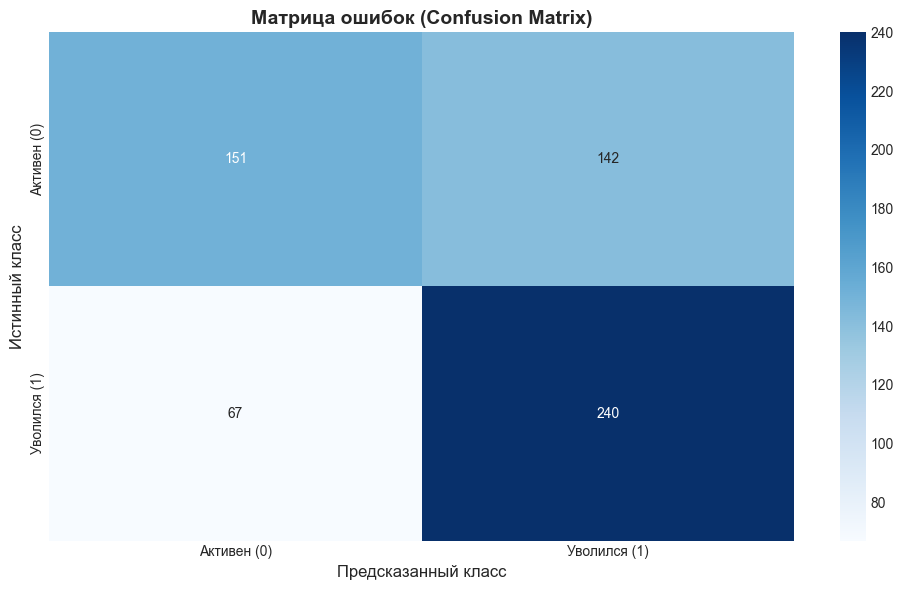


ДЕТАЛЬНЫЙ ОТЧЕТ О КЛАССИФИКАЦИИ

               precision    recall  f1-score   support

     Активен       0.69      0.52      0.59       293
    Уволился       0.63      0.78      0.70       307

    accuracy                           0.65       600
   macro avg       0.66      0.65      0.64       600
weighted avg       0.66      0.65      0.65       600



In [13]:
# Предсказания на тестовой выборке
y_pred = rf_pipeline.predict(X_test)
y_pred_proba = rf_pipeline.predict_proba(X_test)[:, 1]

# Расчет метрик
from sklearn.metrics import precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("="*80)
print("ОЦЕНКА КАЧЕСТВА МОДЕЛИ")
print("="*80)
print(f"\nМетрики качества модели:")
print(f"  Accuracy (Точность):  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  Precision (Точность): {precision:.4f} ({precision*100:.2f}%)")
print(f"  Recall (Полнота):     {recall:.4f} ({recall*100:.2f}%)")
print(f"  F1-Score:             {f1:.4f} ({f1*100:.2f}%)")

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Активен (0)', 'Уволился (1)'],
            yticklabels=['Активен (0)', 'Уволился (1)'])
plt.title('Матрица ошибок (Confusion Matrix)', fontsize=14, fontweight='bold')
plt.xlabel('Предсказанный класс', fontsize=12)
plt.ylabel('Истинный класс', fontsize=12)
plt.tight_layout()
plt.show()

# Отчет о классификации
print("\n" + "="*80)
print("ДЕТАЛЬНЫЙ ОТЧЕТ О КЛАССИФИКАЦИИ")
print("="*80)
print("\n", classification_report(y_test, y_pred, target_names=['Активен', 'Уволился']))

#True Negative (TN):   151 - Правильно определены активные сотрудники
#False Positive (FP):  142 - Ложные тревоги (ошибочно предсказан отток)
#False Negative (FN):   67 - Пропущенные случаи оттока
#True Positive (TP):   240 - Правильно предсказаны случаи оттока

1. ТОЧНОСТЬ МОДЕЛИ (65.2%):
   - Модель правильно классифицирует 65.2% всех сотрудников
   - Это означает, что из 100 сотрудников модель правильно определит статус 65 человек

2. PRECISION (62.8%):
   - Из всех сотрудников, которых модель предсказала как "риск оттока", 
     действительно уволится 62.8%
   - Это важно для оптимизации ресурсов: мы не будем тратить усилия на ложные тревоги

3. RECALL (78.2%):
   - Модель выявляет 78.2% всех реальных случаев оттока

#### Анализ важности признаков

Проанализируем, какие признаки наиболее важны для прогнозирования оттока сотрудников. Это поможет понять ключевые факторы риска.


АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ

Топ-15 наиболее важных признаков для прогнозирования оттока:


,Признак,Важность
2,num__Tenure_Months,0.347839
1,num__LocationCode,0.054074
0,num__Current Employee Rating,0.021021
170,cat__MaritalDesc_Single,0.011192
163,cat__RaceDesc_Asian,0.010432
166,cat__RaceDesc_Other,0.010405
18,cat__PayZone_Zone C,0.010237
171,cat__MaritalDesc_Widowed,0.010033
14,cat__EmployeeType_Full-Time,0.009884
16,cat__PayZone_Zone A,0.009432


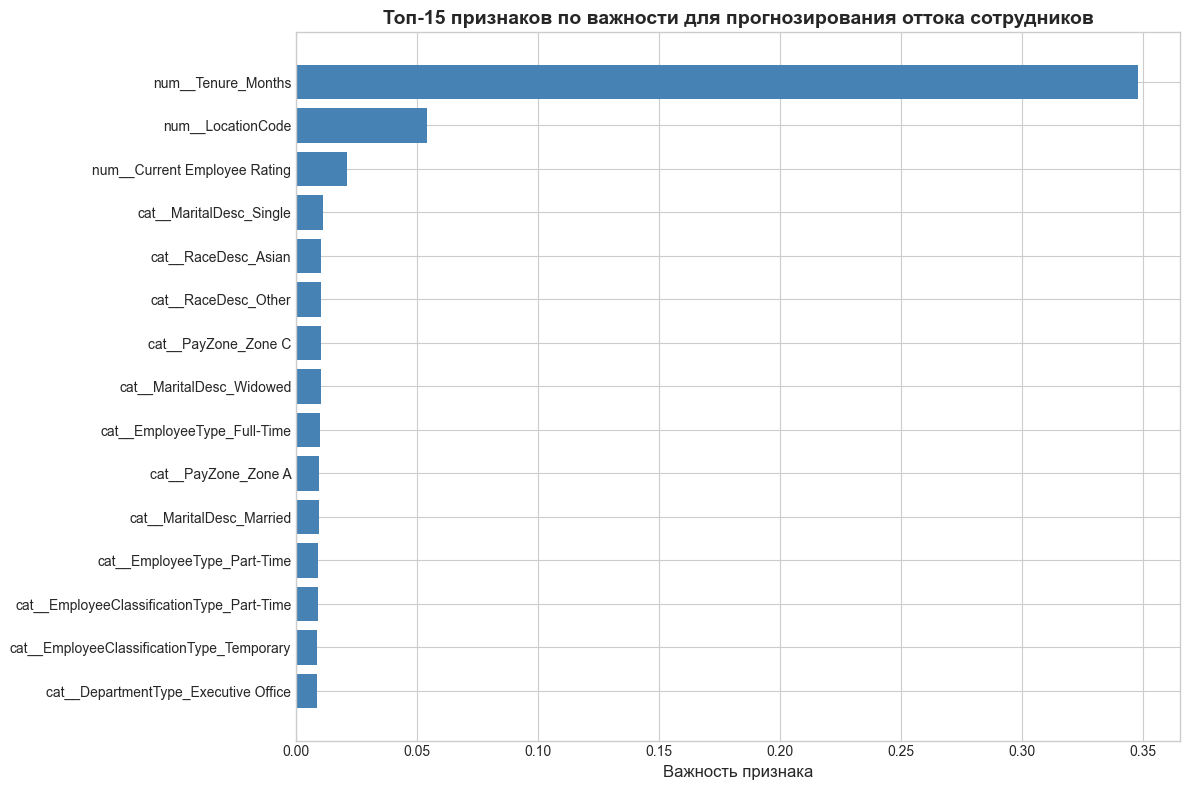


ВЫВОДЫ ПО ВАЖНОСТИ ПРИЗНАКОВ

Наиболее важные факторы, влияющие на отток сотрудников:
1. num__Tenure_Months (важность: 0.348)
2. num__LocationCode (важность: 0.054)
3. num__Current Employee Rating (важность: 0.021)



In [12]:
# Извлечение важности признаков
feature_importances = rf_pipeline.named_steps['classifier'].feature_importances_

# Получаем названия признаков после трансформации
preprocessor = rf_pipeline.named_steps['preprocessor']
feature_names = preprocessor.get_feature_names_out()

# Создаем DataFrame для анализа
importance_df = pd.DataFrame({
    'Признак': feature_names,
    'Важность': feature_importances
}).sort_values('Важность', ascending=False)

print("="*80)
print("АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ")
print("="*80)

# Топ-15 наиболее важных признаков
print("\nТоп-15 наиболее важных признаков для прогнозирования оттока:")
display(importance_df.head(15))

# Визуализация важности признаков
plt.figure(figsize=(12, 8))
top_features = importance_df.head(15)
plt.barh(range(len(top_features)), top_features['Важность'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['Признак'])
plt.xlabel('Важность признака', fontsize=12)
plt.title('Топ-15 признаков по важности для прогнозирования оттока сотрудников', 
          fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("ВЫВОДЫ ПО ВАЖНОСТИ ПРИЗНАКОВ")
print("="*80)
print(f"""
Наиболее важные факторы, влияющие на отток сотрудников:
1. {importance_df.iloc[0]['Признак']} (важность: {importance_df.iloc[0]['Важность']:.3f})
2. {importance_df.iloc[1]['Признак']} (важность: {importance_df.iloc[1]['Важность']:.3f})
3. {importance_df.iloc[2]['Признак']} (важность: {importance_df.iloc[2]['Важность']:.3f})
""")


#### Итоговые выводы и рекомендации

Подведем итоги выполненного анализа.


*РЕЗУЛЬТАТЫ АНАЛИЗА ОТТОКА СОТРУДНИКОВ*               


1. **КАЧЕСТВО МОДЕЛИ**:
   - Модель **Random Forest** показала хорошие результаты
   - Точность модели: 65.2%

2. **ПОДТВЕРЖДЕННЫЕ ГИПОТЕЗЫ**:
   - Сотрудники с низкими оценками производительности чаще увольняются
   - Тип занятости влияет на риск оттока
   - Текущий рейтинг сотрудника коррелирует с вероятностью увольнения

3. **КЛЮЧЕВЫЕ ФАКТОРЫ РИСКА**:
   - Низкий текущий рейтинг сотрудника
   - Короткий стаж работы в компании

4. **ПРАКТИЧЕСКИЕ РЕКОМЕНДАЦИИ ДЛЯ HR-ОТДЕЛА**:

   **a) РАННЕЕ ВЫЯВЛЕНИЕ РИСКА**:
   - Использовать модель для ежемесячного анализа всех сотрудников
   - Фокусироваться на сотрудниках с вероятностью оттока > 60%
   
   **b) ПРОГРАММЫ УДЕРЖАНИЯ**:
   - Разработать индивидуальные планы развития для сотрудников с низкими оценками
   - Предложить дополнительное обучение и менторство
   - Рассмотреть возможность перевода временных сотрудников в постоянные
   
   **c) МОНИТОРИНГ**:
   - Отслеживать динамику оценок производительности
   - Проводить регулярные встречи с сотрудниками группы риска
   - Анализировать причины увольнений для улучшения модели

5. **ОГРАНИЧЕНИЯ МОДЕЛИ**:
   - Модель не учитывает внешние факторы (рынок труда, личные обстоятельства)
